<a href="https://colab.research.google.com/github/hargurjeet/DeepLearning/blob/main/Fruit_360_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit 360 Dataset

# 1: About the Dataset

Total number of images: 90483.

Training set size: 67692 images (one fruit or vegetable per image).

Test set size: 22688 images (one fruit or vegetable per image).

Number of classes: 131 (fruits and vegetables).

Image size: 100x100 pixels.

Filename format: imageindex100.jpg (e.g. 32100.jpg) or rimageindex100.jpg (e.g. r32100.jpg) or r2imageindex100.jpg or r3imageindex100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels).

Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

2: Data Pre Processing

Since we are using PyTorch to build the neural network. I import all the related library in single go.

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 2: Data Pre Processing

## 2.1 Downloading the dataset

In [2]:
# Upload kaggle.jason
# please follow this link incase not aware: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Saving kaggle.json to kaggle (1).json
Requirement already up-to-date: opendatasets in /usr/local/lib/python3.7/dist-packages (0.1.11)


  0%|          | 0.00/760M [00:00<?, ?B/s]

100%|██████████| 760M/760M [00:06<00:00, 115MB/s]


Before we run any exploration the dataset has to be loaded to a dataloader

In [3]:
data_dir = '/content/fruits/fruits-360/'

dataset = ImageFolder(data_dir + "Training", transform=ToTensor())

test_dataset = ImageFolder(data_dir + "Test", transform=ToTensor())

# 3: Exploring the dataset

## Q: How many images does the training and testing dataset contain?

In [4]:
dataset_size = len(dataset)
test_dataset_size = len(test_dataset)
print(dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: /content/fruits/fruits-360/Training
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: /content/fruits/fruits-360/Test
    StandardTransform
Transform: ToTensor()


## Q: How many output classes does the dataset contain?

In [5]:
# Accesssing the classes
data_dir = '/content/fruits/fruits-360/'

# print(os.listdir(data_dir))
classes = os.listdir(data_dir + "Training")
print(f'Total Number of Classe {len(classes)}')
print(f'Classes Names: {classes}')

Total Number of Classe 131
Classes Names: ['Grape White 4', 'Pear Forelle', 'Pear Abate', 'Apple Red Yellow 1', 'Pineapple Mini', 'Grapefruit Pink', 'Lychee', 'Apple Golden 2', 'Pear 2', 'Apple Red 2', 'Nectarine', 'Apple Granny Smith', 'Cherry Rainier', 'Corn Husk', 'Onion Red', 'Rambutan', 'Mango', 'Cantaloupe 2', 'Potato Sweet', 'Pear Monster', 'Corn', 'Beetroot', 'Plum 3', 'Banana', 'Pepper Orange', 'Cherry 1', 'Kiwi', 'Pepino', 'Pear Williams', 'Passion Fruit', 'Nectarine Flat', 'Clementine', 'Pomegranate', 'Blueberry', 'Cherry Wax Yellow', 'Hazelnut', 'Tomato 1', 'Strawberry Wedge', 'Cocos', 'Huckleberry', 'Melon Piel de Sapo', 'Cucumber Ripe', 'Pear Stone', 'Apple Pink Lady', 'Pepper Yellow', 'Dates', 'Onion Red Peeled', 'Physalis with Husk', 'Grape White 3', 'Carambula', 'Cherry Wax Black', 'Nut Forest', 'Plum', 'Tomato Maroon', 'Apple Red 1', 'Tomato Cherry Red', 'Peach', 'Apple Crimson Snow', 'Mangostan', 'Pear Red', 'Pineapple', 'Nut Pecan', 'Pear Kaiser', 'Avocado ripe', 'Q

## Q: What is the shape of an image tensor from the dataset?

In [6]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 100, 100])

Let us print a sample image along with its class and label.

Label (numeric): 0
Label (textual): Grape White 4


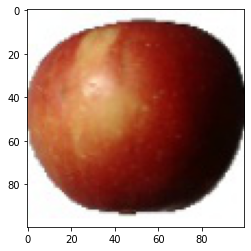

In [7]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

## Q: Can you determine the number of images belonging to each class?

In [8]:
# dataset_size = len(dataset)
# classes = dataset.classes
# num_classes = len(dataset.classes)

# img_dict = {}
# for i in range(num_classes):
#     img_dict[classes[i]] = 0
    
# for i in range(dataset_size):
#     img, label = dataset[i]
#     img_dict[classes[label]] += 1

# img_dict

# 4: Applying Data normalization and Data augmentation

## 4.1 Builiding data transforms

We will first write the transform function so that data augmmentation and channel normalization can be implemented.

To implement channel normalization first we will calculate mean and SD for RBG channel

In [9]:
from PIL import Image
import cv2
import os
import numpy as np
m_list, s_list, imgs = [], [], []

for clas in os.listdir(data_dir + "/Training"):
    for fname in os.listdir(data_dir +'/Training/' + clas):
      img = cv2.imread(data_dir + '/Training/' + clas + '/' + fname)
      img = img / 255.

      m, s = cv2.meanStdDev(img)

      m_list.append(m.reshape((3,)))
      s_list.append(s.reshape((3,)))
      # print(m_list)

m_array = np.array(m_list)
s_array = np.array(s_list)
m = m_array.mean(axis=0, keepdims=True)
s = s_array.mean(axis=0, keepdims=True)
print('mean: ',m[0][::-1])
print('std:  ',s[0][::-1])


mean:  [0.68405327 0.57865809 0.5038885 ]
std:   [0.25893195 0.32171392 0.36558618]


I will round of the mean and SD upto 4 digits and move them to a tuple

In [10]:
means = [round(num, 4) for num in m[0][::-1]]
stds = [round(num, 4) for num in s[0][::-1]]
means, stds = tuple(means), tuple(stds)
stats = means, stds
stats

((0.6841, 0.5787, 0.5039), (0.2589, 0.3217, 0.3656))

In [11]:
# Data transforms (normalization & data augmentation)
train_tfms = tt.Compose([
                         tt.RandomCrop(100, padding=4, padding_mode='reflect'), 
                         tt.Resize((100,100)),
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True),

                         ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Resize((100,100)),
                         tt.Normalize(*stats)
                         ])

## 4.2 Applying the transfroms to the dataset

In [12]:
dataset = ImageFolder(data_dir + "/Training", transform=train_tfms)

Testing = ImageFolder(data_dir + "/Test", transform=valid_tfms)

## 4.3 Splitting the dataset

We'll use a validation set of 20% from the training set. To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [13]:
torch.manual_seed(43)
val_size = round(len(dataset) * 0.2)
train_size = round(len(dataset) - val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(54154, 13538)

In [14]:
batch_size=400

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

# 5: Accessing few sample images

Let's visualize a batch of data using the make_grid helper function from Torchvision.

In [15]:
# from torchvision.utils import make_grid

# def denormalize(images, means, stds):
#     means = torch.tensor(means).reshape(1, 3, 1, 1)
#     stds = torch.tensor(stds).reshape(1, 3, 1, 1)
#     return images * stds + means

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 6))
#         ax.set_xticks([]); ax.set_yticks([])
#         denorm_images = denormalize(images, *stats)
#         ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
#         break

# show_batch(train_loader)

Can you label all the images by looking at them? Trying to label a random sample of the data manually is a good way to estimate the difficulty of the problem, and identify errors in labeling, if any

# 6: Accessing GPU

You can use a Graphics Processing Unit (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

- Google Colab: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
- Kaggle: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
- Binder: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
- Linux: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the NVIDIA CUDA drivers.
- Windows: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the NVIDIA CUDA drivers.
macOS: macOS is not compatible with NVIDIA GPUs
- If you do not have access to a GPU or aren't sure what it is, don't worry, you can execute all the code in this tutorial just fine without a GPU.

Let's begin by installing and importing the required libraries.

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

# 7: Configuring the model

## 7.1: Setting up Accuracy funtion and Image base class

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## 7.2 Implementing Batch normalization and Dropout

In [20]:
class Fruit360CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # nn.AdaptiveAvgPool2d(100),
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32 X 100 X 100
            nn.BatchNorm2d(32),
            nn.ReLU(), # 32 X 100 X 100
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 X 50 X 50

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(5, 5), # output: 256 x 5 x 5

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*5*5, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 131))
        
    def forward(self, xb):
      return self.network(xb)

model = Fruit360CnnModel()
model

Fruit360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1),

## 7.3 Implementing Weight Decay, Gradient clipping, Adam optimizer while training

In [21]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(model, device)
model

Fruit360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1),

In [23]:
os.environ['WANDB_CONSOLE'] = 'off'

history = [evaluate(model, valid_dl)]
history


[{'val_acc': 0.00633588433265686, 'val_loss': 4.875503063201904}]

In [24]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [25]:
%%time

os.environ['WANDB_CONSOLE'] = 'off'

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 0.7136, val_loss: 6.3051, val_acc: 0.2792
Epoch [1], train_loss: 0.0832, val_loss: 0.8349, val_acc: 0.7903
Epoch [2], train_loss: 0.0328, val_loss: 0.0792, val_acc: 0.9801
Epoch [3], train_loss: 0.0163, val_loss: 0.0013, val_acc: 0.9999
Epoch [4], train_loss: 0.0012, val_loss: 0.0007, val_acc: 0.9999
CPU times: user 2min 14s, sys: 2min 1s, total: 4min 15s
Wall time: 6min 21s


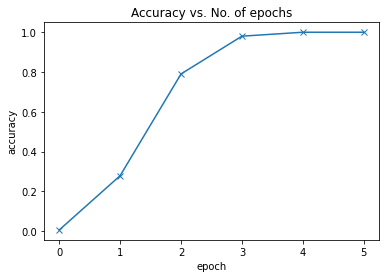

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

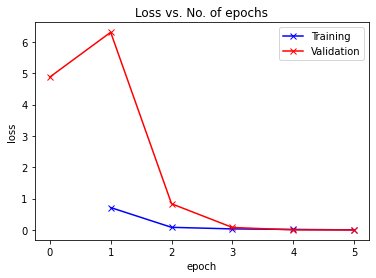

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

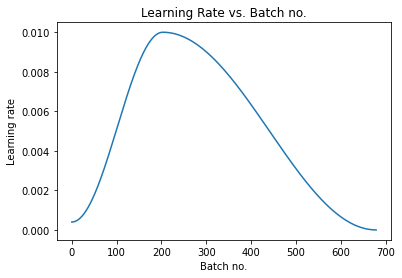

In [29]:
plot_lrs(history)

In [38]:
test_tfms = tt.Compose([tt.Resize((100, 100)), 
                        tt.ToTensor()])

In [39]:
test_dataset = ImageFolder(data_dir + "Test", transform=test_tfms)

In [40]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.009298245422542095, 'val_loss': 12.801467895507812}

In [41]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Apple Braeburn , Predicted: Cherry Rainier


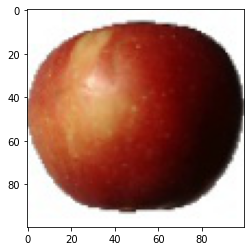

In [42]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Braeburn , Predicted: Cherry Rainier


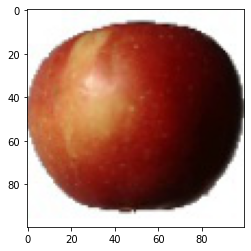

In [43]:
img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Banana Red , Predicted: Pepino


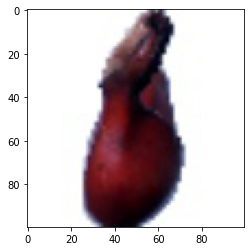

In [45]:
img, label = test_dataset[3000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))